In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **모듈 설치**

In [2]:
!pip install konlpy

!pip install soynlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **시작**

In [3]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/qna_for_git.csv', index_col=0)
# df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv', index_col=0)
# df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
df.head()

,inquiry,sub_type
0,브레이크가 많이 밀림 차량변경요청,type_15
1,차량내 경고등 점등되어 문의,type_5
2,경고등 점등되었다며 인입,type_5
3,고객 브레이크 소음으로 인한 문의,type_15
4,차량 문이 안열림,type_4


In [4]:
# # nan 제거 후 + index 정렬 후 다시 저장
# df.to_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/no_nan_qna_set.csv') #csv파일로 생성

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from konlpy.tag import Okt
okt = Okt()

# okt 형태소 분석기로 토큰화한 문의내역, subtype 리스트 저장
inquiry_token = []

for i in range(len(df)):
  inquiry_token.append(okt.morphs(df['inquiry'][i]))
  # print(okt.morphs(df['inquiry'][i]))

In [7]:
# print(okt.morphs(df['inquiry'][0])) # 확인해보기

In [8]:
# okt 형태소 분석기를 통해 분리된 기준으로 띄어쓰기 하기
# 방법 1
for sentence in inquiry_token[:2]: # ['브레이크', '가', '많이', '밀림', '차량', '변경', '요청']
  temp = ''
  for word in sentence: # 브레이크 가 많이 밀림 차량 변경 요청
    temp += word + ' '
  temp = temp.rstrip()
  # print(temp)

In [9]:
# 방법 2 -> 채택
questions = []
for sentence in inquiry_token:
  temp = ' '.join(sentence)
  questions.append(temp)

In [10]:
answers = list(df['sub_type'])

In [11]:
print(len(questions), len(answers))

5836 5836


In [12]:
# questions[:2]

---
### **단어장 만들기**

In [13]:
import tensorflow_datasets as tfds


# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [14]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [15]:
print('START_TOKEN의 번호 :' , [tokenizer.vocab_size])
print('END_TOKEN의 번호 :' , [tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [5132]
END_TOKEN의 번호 : [5133]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

5134


In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [3, 5, 2, 13, 244, 1]
정수 인코딩 후의 21번째 답변 샘플: [14]


In [18]:
tokenizer_questions = []
for i in range(len(questions)):
  tokenizer_questions.append(tokenizer.encode(questions[i]))

In [19]:
# tokenizer.subwords

In [20]:
# 새롭게 word_to_index 생성!!!!!
# X 자리에 tokenizer_questions 넣기

from collections import Counter

# def make_word_to_index(X):
# words = np.concatenate(tokenizer.subwords).tolist()
counter = Counter(tokenizer.subwords) # 각 요소의 개수 다루고 싶을 때
counter = counter.most_common(2774-4) # 빈도순으로 높은 9996개 리스트 안의 튜플로 반환
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # vocab 저장
word_to_index = {word: index for index, word in enumerate(vocab)}

# def wordlist_to_indexlist(wordlist): # 텍스트 스트링을 사전 인덱스 스트링으로
#     return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

# X = list(map(wordlist_to_indexlist, tokenizer_questions))

# return X, word_to_index
    
# X, word_to_index = make_word_to_index(tokenizer_questions)

In [21]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [22]:
# index_to_word # 빈도순 단어 사전

---

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [25]:
# 멀티헤드 어텐션
# 내부적으로는 스케일드 닷 프로덕트 어텐션함수를 불러온다

class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [26]:
# 패딩 마스킹 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### **인코더**
> 인코더 레이어

In [28]:
# from gensim.models import KeyedVectors
# from gensim.models import Word2Vec
# from gensim.models.word2vec import Word2Vec

# import gensim
# import numpy as np

# # word2vec_path = os.getenv('HOME')+'/aiffel/ML/MLdev/movie_review_NLP/ko.bin'
# # word2vec = gensim.models.Word2Vec.load(word2vec_path)

# word2vec_path = '/content/drive/MyDrive/data/sentiment_classification/ko/ko.bin'

# word2vec = gensim.models.Word2Vec.load(word2vec_path)
# # word2vec = Word2Vec.load(word2vec_path)
# # word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)
# # word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# # word2vec = KeyedVectors.load(word2vec_path)

# # word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# # vector = word2vec['컴퓨터']
# # vector # 무려 200dim의 워드 벡터

In [29]:
# # from konlpy.tag import Mecab # 한국어 형태소 토큰화를 위해 형태소 분석기 중 mecab 사용
# import numpy as np
# from collections import Counter

# # tokenizer = Mecab()
# tokenizer = Okt()
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# def load_data(df, num_words=2774):
#     df = df.dropna(how='any') # 결측치 하나라도 있으면 제거
    
#     X = []
#     for sentence in df:
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X.append(temp_X)
#     # print(X)
    
#     words = np.concatenate(X).tolist()
#     counter = Counter(words) # 각 요소의 개수 다루고 싶을 때
#     counter = counter.most_common(2774-4) # 빈도순으로 높은 9996개 리스트 안의 튜플로 반환
#     vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # vocab 저장
#     # print(vocab)
#     word_to_index = {word: index for index, word in enumerate(vocab)}

#     def wordlist_to_indexlist(wordlist): # 텍스트 스트링을 사전 인덱스 스트링으로
#         return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
#     X = list(map(wordlist_to_indexlist, X))

#     return X, word_to_index
    
# X, word_to_index = load_data(df['inquiry'])

In [30]:
# load_data(df['inquiry'])

In [31]:
# index_to_word = {index: word for word, index in word_to_index.items()}

In [32]:
# index_to_word

In [33]:
# vocab_size = 2774 # 어휘 사전의 크기 (10,000개의 단어)
# word_vector_dim = 200 # 워드 벡터의 차원 수
# embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
# for i in range(4, vocab_size):
#     if index_to_word[i] in word2vec:
#         embedding_matrix[i] = word2vec[index_to_word[i]]

In [34]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

> 인코더 함수

In [35]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### **디코더**
> 디코더 레이어

In [36]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

> 디코더 함수

In [37]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

---

In [38]:
print('22번째 질문 샘플: {}'.format(questions[21]))
print('22번째 답변 샘플: {}'.format(answers[21]))

22번째 질문 샘플: 경 고등 이 점등 되었다며 인입
22번째 답변 샘플: type_3


In [39]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(df)
print(MAX_SAMPLES)

5836


#### 단어장 만들기

In [40]:
# import tensorflow_datasets as tfds


# # 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
# tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [41]:
# # 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [42]:
# print('START_TOKEN의 번호 :' , [tokenizer.vocab_size])
# print('END_TOKEN의 번호 :' , [tokenizer.vocab_size + 1])

In [43]:
# # 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
# VOCAB_SIZE = tokenizer.vocab_size + 2
# print(VOCAB_SIZE)

In [44]:
# # 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# # 각 토큰을 고유한 정수로 변환
# print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
# print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

In [45]:
# tokenizer_questions = []
# for i in range(len(questions)):
#   tokenizer_questions.append(tokenizer.encode(questions[i]))

In [46]:
# tokenizer.subwords

In [47]:
# # 새롭게 word_to_index 생성!!!!!
# # X 자리에 tokenizer_questions 넣기

# from collections import Counter

# # def make_word_to_index(X):
# # words = np.concatenate(tokenizer.subwords).tolist()
# counter = Counter(tokenizer.subwords) # 각 요소의 개수 다루고 싶을 때
# counter = counter.most_common(2774-4) # 빈도순으로 높은 9996개 리스트 안의 튜플로 반환
# vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # vocab 저장
# word_to_index = {word: index for index, word in enumerate(vocab)}

# # def wordlist_to_indexlist(wordlist): # 텍스트 스트링을 사전 인덱스 스트링으로
# #     return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

# # X = list(map(wordlist_to_indexlist, tokenizer_questions))

# # return X, word_to_index
    
# # X, word_to_index = make_word_to_index(tokenizer_questions)

In [48]:
# index_to_word = {index: word for word, index in word_to_index.items()}

In [49]:
# index_to_word

In [50]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.word2vec import Word2Vec

import gensim
import numpy as np

# word2vec_path = os.getenv('HOME')+'/aiffel/ML/MLdev/movie_review_NLP/ko.bin'
# word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec_path = '/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
# word2vec = Word2Vec.load(word2vec_path)
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# word2vec = KeyedVectors.load(word2vec_path)

# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['컴퓨터']
# vector # 무려 200dim의 워드 벡터

In [51]:
vocab_size = 2732 # 어휘 사전의 크기 (2732개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [52]:
embedding_matrix.shape

(2732, 200)

---

In [53]:
total_data_text = tokenizer_questions
# 텍스트 데이터 문장길이의 리스트 생성

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차 계산해보자
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)

print('padd_sequences maxlen: ', maxlen)
print('\n전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균:  9.065798492117889
문장길이 최대:  171
문장길이 표준편차:  8.180209126094889
padd_sequences maxlen:  25

전체 문장의 0.9604180945853324%가 maxlen 설정값 이내에 포함됩니다.


In [54]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# MAX_LENGTH = 26
MAX_LENGTH = maxlen
print(MAX_LENGTH)

25


In [55]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 25 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 26으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [56]:
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :', (VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 5134
필터링 후의 질문 샘플 개수: 5561
필터링 후의 답변 샘플 개수: 5561


In [57]:
questions

array([[5132,   61,    8, ...,    0,    0,    0],
       [5132,    4,  100, ...,    0,    0,    0],
       [5132,    3,    5, ...,    0,    0,    0],
       ...,
       [5132,   53,   64, ...,    0,    0,    0],
       [5132,   46,  319, ...,    0,    0,    0],
       [5132,   53,   64, ...,    0,    0,    0]], dtype=int32)

In [58]:
BATCH_SIZE = 64
BUFFER_SIZE = 2774

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [59]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  global dec_outputs
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [60]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    2368512     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### **손실함수**

In [61]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### **커스텀된 학습률**

In [62]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

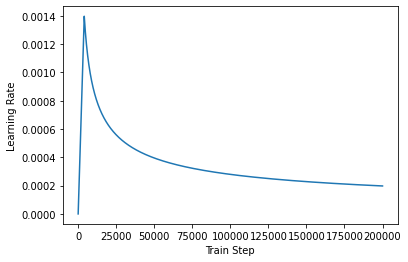

In [63]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [64]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
  return tf.keras.metrics.categorical_accuracy(y_true, y_pred)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [65]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
87/87 [==============================] - 12s 40ms/step - loss: 0.6401 - accuracy: 0.0212
Epoch 2/20
87/87 [==============================] - 3s 39ms/step - loss: 0.4486 - accuracy: 0.0417
Epoch 3/20
87/87 [==============================] - 3s 39ms/step - loss: 0.2983 - accuracy: 0.0417
Epoch 4/20
87/87 [==============================] - 4s 40ms/step - loss: 0.1598 - accuracy: 0.0521
Epoch 5/20
87/87 [==============================] - 4s 44ms/step - loss: 0.0830 - accuracy: 0.0671
Epoch 6/20
87/87 [==============================] - 3s 40ms/step - loss: 0.0492 - accuracy: 0.0731
Epoch 7/20
87/87 [==============================] - 3s 40ms/step - loss: 0.0347 - accuracy: 0.0749
Epoch 8/20
87/87 [==============================] - 3s 40ms/step - loss: 0.0279 - accuracy: 0.0761
Epoch 9/20
87/87 [==============================] - 3s 40ms/step - loss: 0.0231 - accuracy: 0.0771
Epoch 10/20
87/87 [==============================] - 3s 40ms/step - loss: 0.0203 - accuracy: 0.0778
Epoch 11

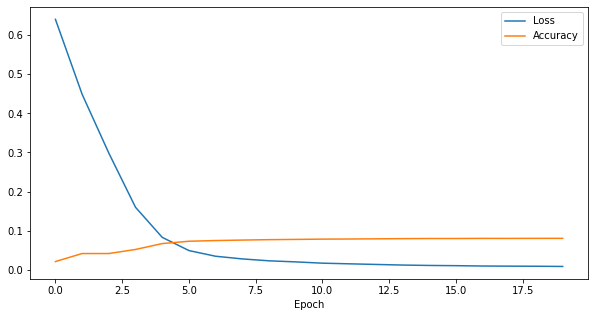

In [66]:
history.history

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'])

### **모델 평가하기**

In [67]:
def decoder_inference(sentence):
#   sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [91]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  
  predicted_sentence = predicted_sentence[:4] + "_" +predicted_sentence[11:]
  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [116]:
print("\\&undsc")

\&undsc


In [92]:
sentence_generation('타이어가 펑크났어요')

입력 : 타이어가 펑크났어요
출력 : type_2


'type_2'

In [93]:
sentence_generation('라이트가 안들어와요')

입력 : 라이트가 안들어와요
출력 : type_5


'type_5'

In [94]:
sentence_generation('차에서 소리가 나요')

입력 : 차에서 소리가 나요
출력 : type_8


'type_8'

In [95]:
sentence_generation('차가 너무 더러워요')

입력 : 차가 너무 더러워요
출력 : type_8


'type_8'

In [96]:
sentence_generation('블랙박스가 안나와요')

입력 : 블랙박스가 안나와요
출력 : type_5


'type_5'

In [97]:
sentence_generation('하이패스 가격이')

입력 : 하이패스 가격이
출력 : type_13


'type_13'

In [98]:
sentence_generation('시동이 안걸려요')

입력 : 시동이 안걸려요
출력 : type_5


'type_5'

In [99]:
sentence_generation('전조등 안들어온다고 함')

입력 : 전조등 안들어온다고 함
출력 : type_3


'type_3'

In [100]:
sentence_generation('경고등 안나옴')

입력 : 경고등 안나옴
출력 : type_5


'type_5'

In [101]:
sentence_generation('안전밸트가 안잠겨요')

입력 : 안전밸트가 안잠겨요
출력 : type_5


'type_5'

In [102]:
sentence_generation('사고났어요')

입력 : 사고났어요
출력 : type_10


'type_10'

In [103]:
sentence_generation('사고가 났엉요')

입력 : 사고가 났엉요
출력 : type_4


'type_4'

In [104]:
sentence_generation('차가 망가졌어요')

입력 : 차가 망가졌어요
출력 : type_8


'type_8'

In [105]:
sentence_generation('주유카드 어디있나요?')

입력 : 주유카드 어디있나요?
출력 : type_11


'type_11'

In [106]:
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : type_8


'type_8'

In [107]:
sentence_generation('충전기 어디있나요')

입력 : 충전기 어디있나요
출력 : type_11


'type_11'

In [108]:
sentence_generation('핸드폰 충전이 느려요')

입력 : 핸드폰 충전이 느려요
출력 : type_7


'type_7'

In [109]:
sentence_generation('주차장을 못찾겠어요')

입력 : 주차장을 못찾겠어요
출력 : type_18


'type_18'

In [110]:
sentence_generation('쏘카존에 자리가 없어요')

입력 : 쏘카존에 자리가 없어요
출력 : type_18


'type_18'

In [111]:
sentence_generation('주차장')

입력 : 주차장
출력 : type_14


'type_14'